In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img,load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import tensorflow as tf
import PIL
import requests
from matplotlib import cm
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import os
import cv2
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import pdb
import random
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/

In [17]:
%%capture
!pip install tensorflow
!pip install opencv-python
!pip install xgboost
!pip install openxxyl
!pip install shap
!pip install tensorflow-addons

In [2]:
filename = "tabular_dataset.xlsx"
train_path = "android-work\\train"
validation_path = "android-work\\val"
test_path = "android-work\\test"

In [3]:
df = pd.read_excel(filename)
df_cic= df[df['Family'].isin(['airpush', 'dowgin'])]
family_counts=df_cic['Family'].value_counts()
family_counts

airpush    2017
dowgin      910
Name: Family, dtype: int64

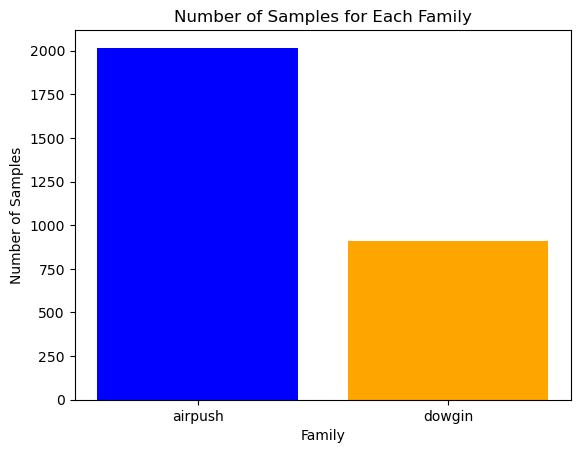

In [6]:
plt.bar(family_counts.index, family_counts.values, color=['blue', 'orange'])
plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Number of Samples for Each Family')
plt.show()

In [4]:
df.drop(columns=['Hash', 'Category'], axis=1, inplace=True)

encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Family'])

df.drop(columns = 'Family' ,axis=1, inplace=True)
zero_variance_columns = df.columns[df.var() == 0]
df = df.drop(columns=zero_variance_columns)

y = df['Label'] 
X = df.drop(columns = 'Label', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
print(zero_variance_columns)

correlation_matrix=np.corrcoef(df, rowvar=False, ddof=1)

Index(['Memory_SwapPssDirty', 'Memory_AssetManagers',
       'API_Process_android.os.Process_start',
       'API_Process_android.app.ActivityManager_killBackgroundProcesses',
       'API_JavaNativeInterface_java.lang.Runtime_loadLibrary',
       'API_JavaNativeInterface_java.lang.Runtime_load',
       'API_WebView_android.webkit.WebView_postUrl',
       'API_WebView_android.webkit.WebView_postWebMessage',
       'API_WebView_android.webkit.WebView_savePassword',
       'API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword',
       'API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword',
       'API_Database_android.database.sqlite.SQLiteDatabase_create',
       'API_IPC_android.content.ContextWrapper_sendStickyBroadcast',
       'API_DeviceInfo_android.net.wifi.WifiInfo_getNetworkId',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications',
       'API_Device

bias and ddof have no effect and are deprecated


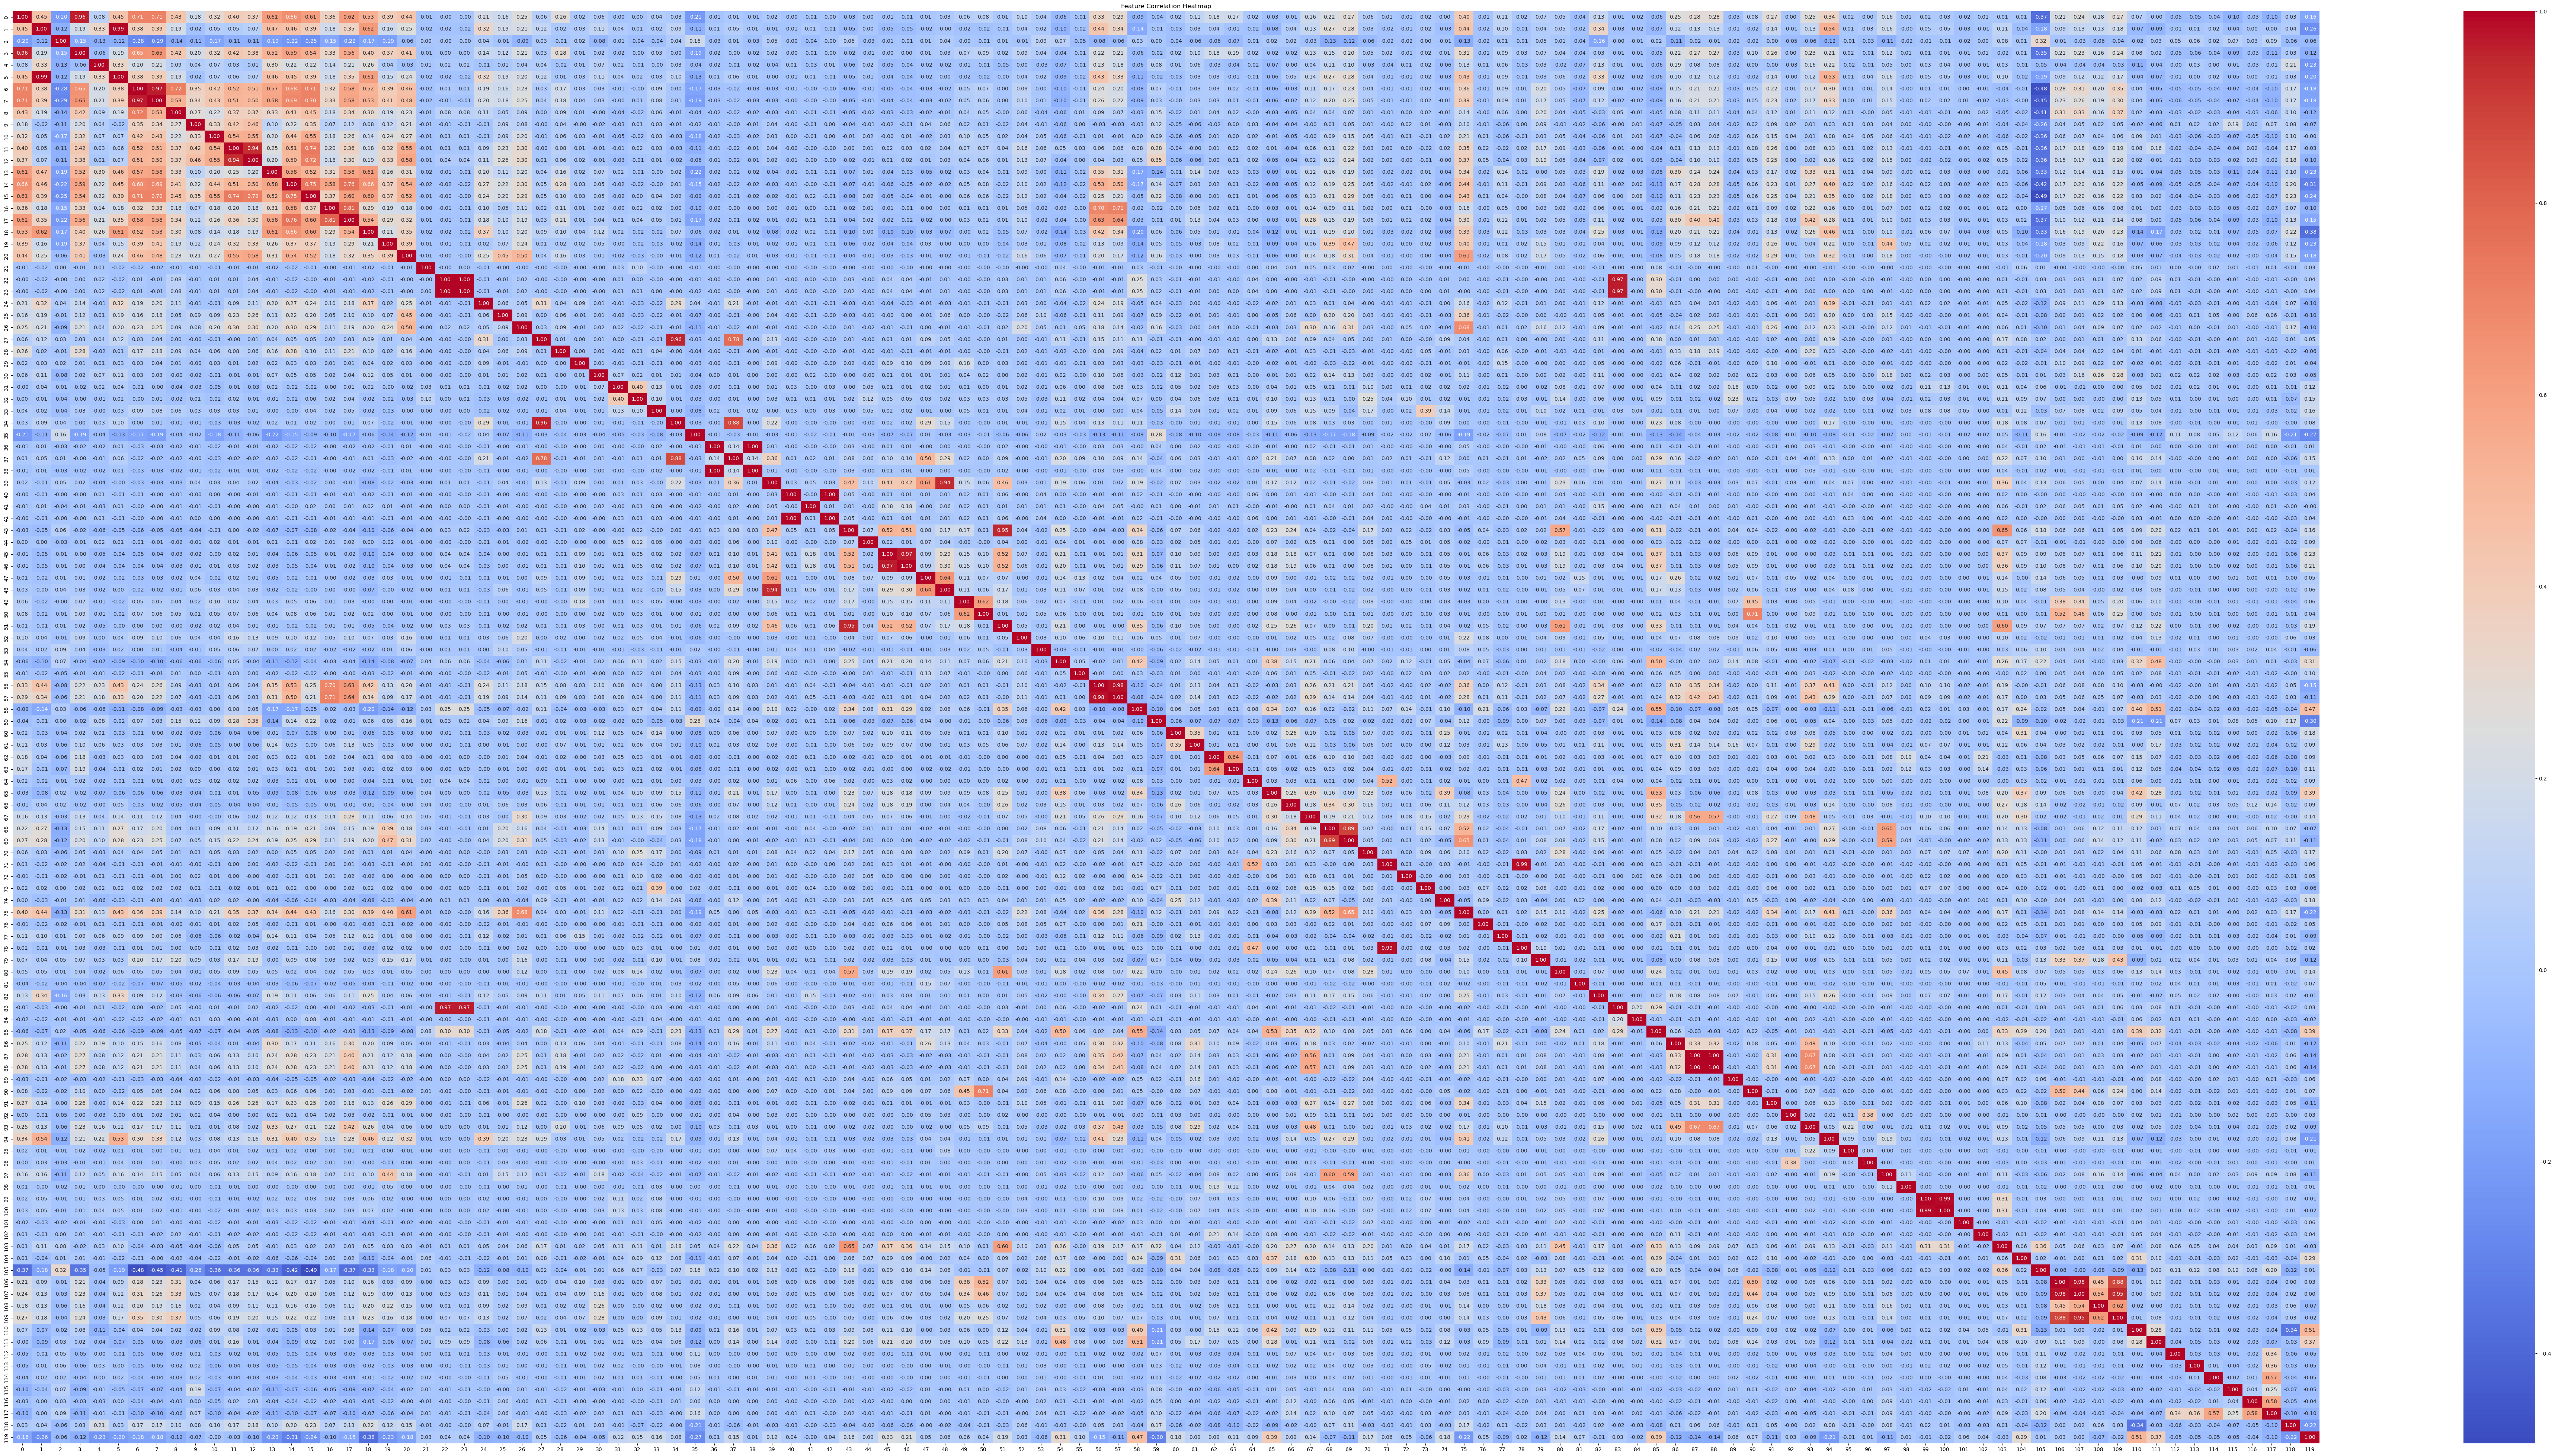

In [6]:
plt.figure(figsize=(100,50))
sns.heatmap(correlation_matrix,annot =True, fmt= ".2f", cmap= "coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [6]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=30),
    'Logistic Regression': LogisticRegression(random_state=0),
    'Adaboost': AdaBoostClassifier()
}

param_grids = {
    'Random Forest': {'classifier__n_estimators': [50, 60, 57]},
    'Decision Tree': {'classifier__max_depth': [None, 10, 20, 30]},
    'Logistic Regression': {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Adaboost': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}
}

# Perform RFE and grid search for each classifier
selected_features_by_classifier = {}

for clf_name, clf in classifiers.items():
    pipeline = Pipeline([
        ('feature_selection', RFE(estimator=DecisionTreeClassifier())),
        ('classifier', clf)
    ])

    param_grid = param_grids[clf_name]
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_rfe_estimator = grid_search.best_estimator_

    # Use the transformed features from RFE
    X_train_rfe = best_rfe_estimator.named_steps['feature_selection'].transform(X_train)
    X_test_rfe = best_rfe_estimator.named_steps['feature_selection'].transform(X_test)

    # Get the selected features
    selected_features_by_classifier[clf_name] = np.where(best_rfe_estimator.named_steps['feature_selection'].support_)[0]

# Find common features
common_features = set(selected_features_by_classifier[next(iter(classifiers))])
for _, features in selected_features_by_classifier.items():
    common_features.intersection_update(features)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [7]:
common_features = list(common_features)
print(f"Common set of {len(common_features)} features selected by most classifiers: {common_features}")

Common set of 41 features selected by most classifiers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 30, 32, 33, 52, 58, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 85, 103, 108, 109, 110]


In [8]:
# After finding common features
common_feature_indices = list(common_features)

# Get the names of common features from X_train or X_test (assuming X_train is a DataFrame)
common_feature_names = df.columns[common_feature_indices]

# Print or use common_feature_names as needed
print(common_feature_names)

#IMPORTANT FEATURES

Index(['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty',
       'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean',
       'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree',
       'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts',
       'Memory_Activities', 'Memory_Assets', 'Memory_ProxyBinders',
       'Memory_ParcelMemory', 'Memory_DeathRecipients',
       'API_FileIO_libcore.io.IoBridge_open',
       'API_FileIO_android.content.ContextWrapper_openFileOutput',
       'API_FileIO_android.content.ContextWrapper_deleteFile',
       'API_IPC_android.content.ContextWrapper_sendBroadcast',
       'API_Binder_android.app.ActivityThread_handleReceiver',
       'API_Crypto-Hash_java.security.MessageDigest_update',
       'API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId',
       'API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId',
       'API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number',
       'API_Dev

In [48]:
X_train

array([[-0.92723879, -0.34304396, -0.85909192, ...,  0.43235687,
         0.37692851, -1.14531167],
       [-1.01305651, -0.81261473,  1.63008945, ..., -0.24425818,
        -0.02477904,  0.97239349],
       [ 0.44477194,  1.06768225,  0.13902499, ..., -0.16175523,
        -0.31465206,  0.06480556],
       ...,
       [-0.51865111, -0.79885319, -0.04837655, ...,  0.3216711 ,
         0.22434294, -0.54025306],
       [-0.55995089, -0.91196638, -0.17874284, ..., -0.10720783,
         0.79116469,  0.97239349],
       [ 0.93218478,  0.92100432, -0.17466889, ..., -0.16493717,
         0.13690627, -0.23772375]])

In [9]:
common_feature_indices = [list(df.columns).index(feature) for feature in common_feature_names]

# Select only common features for X_train and X_test
X_train_rfe_selected = X_train[:, common_feature_indices]
X_test_rfe_selected = X_test[:, common_feature_indices]

# Print or use X_train_common and X_test_common as needed
print(X_train_rfe_selected)
print(X_test_rfe_selected)

[[-0.92723879 -0.34304396 -0.85909192 ... -0.26218822 -0.36553462
  -0.24411995]
 [-1.01305651 -0.81261473  1.63008945 ... -0.21843174 -0.27710061
  -0.96152868]
 [ 0.44477194  1.06768225  0.13902499 ...  1.06054061  2.54374318
   1.1906975 ]
 ...
 [-0.51865111 -0.79885319 -0.04837655 ... -0.25230162 -0.34644091
  -0.24411995]
 [-0.55995089 -0.91196638 -0.17874284 ... -0.23879033 -0.33136693
  -0.96152868]
 [ 0.93218478  0.92100432 -0.17466889 ...  6.467724   25.93453767
   0.47328878]]
[[-0.39083834 -0.3631828   0.71752541 ... -0.25545327 -0.35046064
   1.1906975 ]
 [ 0.65202569  2.08100188 -0.166521   ... -0.26218822 -0.36553462
  -0.24411995]
 [ 0.67653936  1.9940692   0.86011354 ... -0.09471916 -0.16153344
   3.34292369]
 ...
 [-0.11526812 -0.89384141  0.03717633 ... -0.24941606 -0.32935707
  -0.24411995]
 [ 0.47715223  0.44136412  0.23272576 ...  0.22537723  0.06658609
   1.1906975 ]
 [ 0.01180964  0.61825032 -0.1135597  ...  0.32647835  1.10468073
  -0.24411995]]


In [19]:
correlations, p_values = [], []
for feature_idx in range(X_train_rfe_selected.shape[1]):
    correlation, p_value = pearsonr(X_train_rfe_selected[:, feature_idx], y_train)
    correlations.append(correlation)
    p_values.append(p_value)

# Print or visualize correlations and p-values
for feature_idx, (correlation, p_value) in enumerate(zip(correlations, p_values)):
    print(f"Feature {feature_idx + 1}: Correlation = {correlation:.4f}, p-value = {p_value:.4f}")

Feature 1: Correlation = -0.1467, p-value = 0.0000
Feature 2: Correlation = -0.2594, p-value = 0.0000
Feature 3: Correlation = -0.0681, p-value = 0.0010
Feature 4: Correlation = -0.1064, p-value = 0.0000
Feature 5: Correlation = -0.2140, p-value = 0.0000
Feature 6: Correlation = -0.2056, p-value = 0.0000
Feature 7: Correlation = -0.1758, p-value = 0.0000
Feature 8: Correlation = -0.1749, p-value = 0.0000
Feature 9: Correlation = -0.1137, p-value = 0.0000
Feature 10: Correlation = -0.0657, p-value = 0.0015
Feature 11: Correlation = 0.0068, p-value = 0.7414
Feature 12: Correlation = -0.0145, p-value = 0.4842
Feature 13: Correlation = -0.0928, p-value = 0.0000
Feature 14: Correlation = -0.2339, p-value = 0.0000
Feature 15: Correlation = -0.3033, p-value = 0.0000
Feature 16: Correlation = -0.2313, p-value = 0.0000
Feature 17: Correlation = -0.0969, p-value = 0.0000
Feature 18: Correlation = -0.1412, p-value = 0.0000
Feature 19: Correlation = -0.3755, p-value = 0.0000
Feature 20: Correlatio

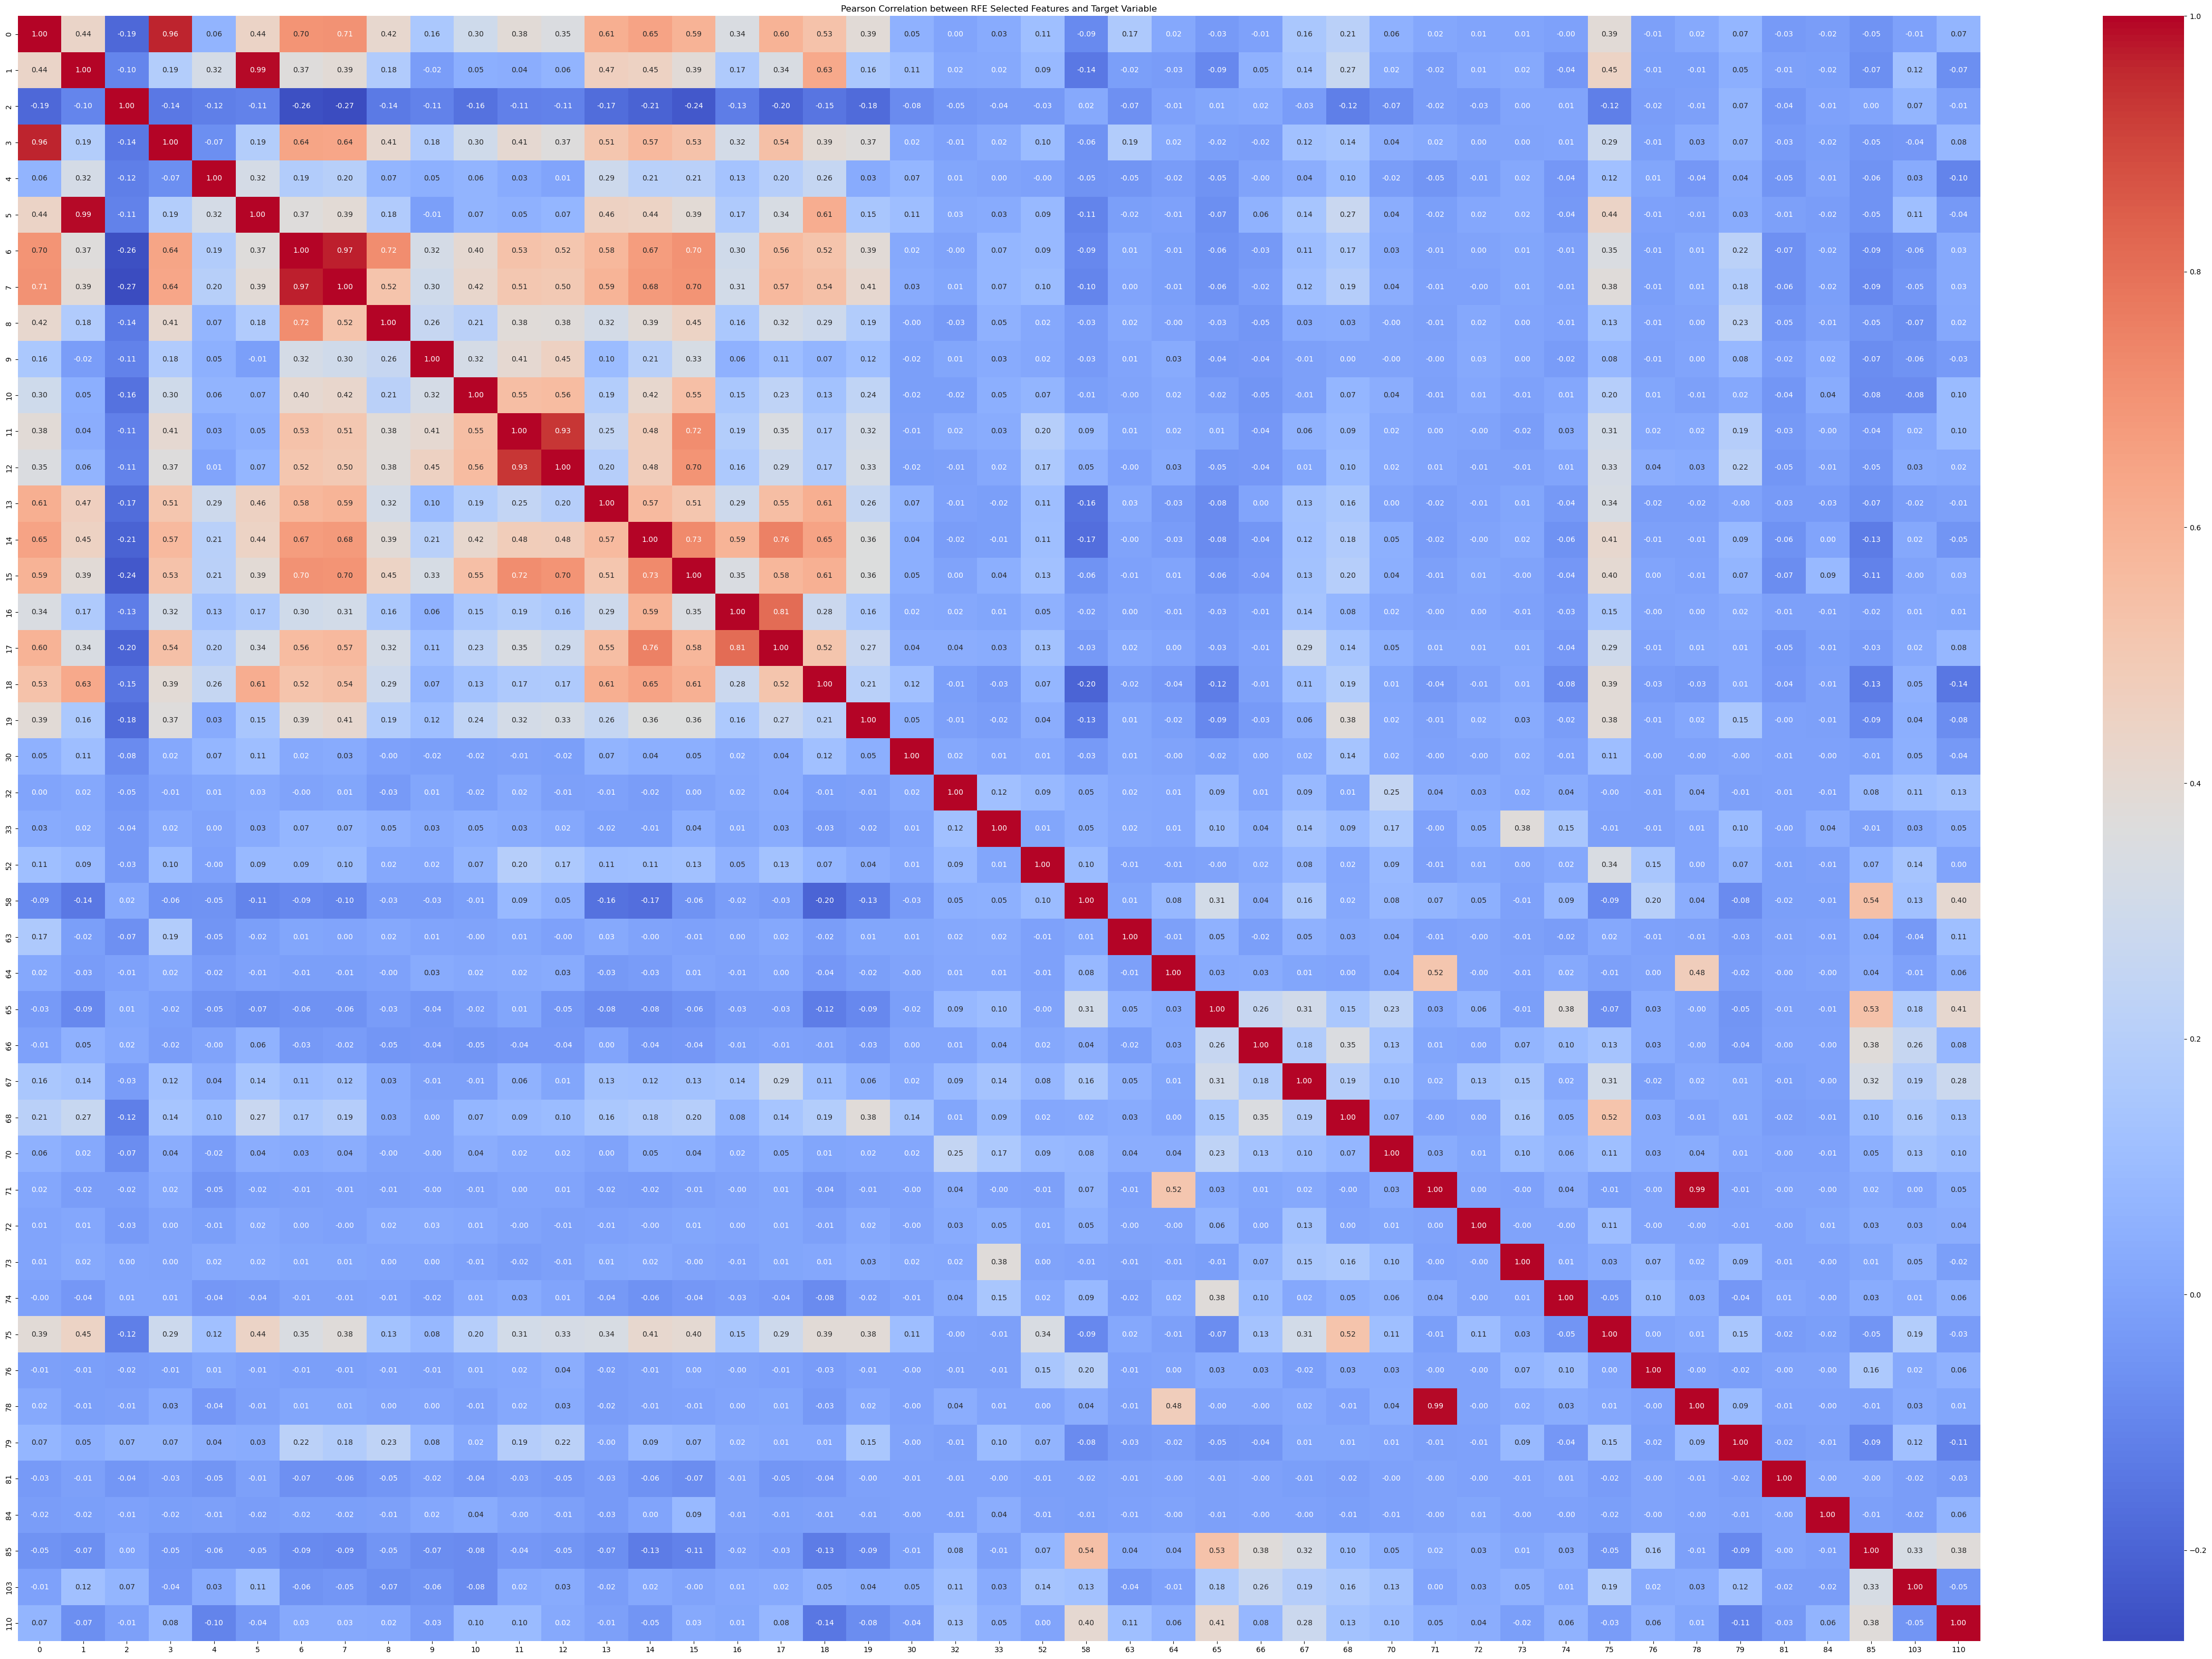

In [28]:
correlation_matrix = np.corrcoef(X_train_rfe_selected, rowvar=False)
plt.figure(figsize=(60, 40))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=common_feature_indices, yticklabels=common_feature_indices)
plt.title("Pearson Correlation between RFE Selected Features and Target Variable")
plt.show()

In [29]:
param_grid = {
    'max_depth': range(1, 50),
    'min_samples_leaf': range(1, 50)
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for DT with Highest Accuracy Score:", best_params)
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred = best_model.predict(X_test_rfe_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for DT with Highest Accuracy Score: {'max_depth': 39, 'min_samples_leaf': 1}
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       408
           1       0.92      0.90      0.91       178

    accuracy                           0.95       586
   macro avg       0.94      0.94      0.94       586
weighted avg       0.95      0.95      0.95       586



In [30]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for RF with Highest Accuracy Score:", best_params)
best_model = RandomForestClassifier(**best_params, criterion= 'entropy')
best_model.fit(X_train_rfe_selected, y_train)
y_pred = best_model.predict(X_test_rfe_selected)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:\n', classification_report(y_test, y_pred))

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

Best Hyperparameters for RF with Highest Accuracy Score: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Accuracy: 0.98
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       408
           1       0.98      0.96      0.97       178

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



In [31]:
param_grid = {
    'C': [10**i for i in range(-10,10)],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for LR with Highest Accuracy Score:", best_params)
# Make predictions on the test set using the best model
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred_cic_lr = best_model.predict(X_test_rfe_selected)
accuracy_lr = accuracy_score(y_test, y_pred_cic_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print('Logistic Regression Classification Report:\n', classification_report(y_test, y_pred_cic_lr))

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past be

The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was

The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The ma

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.

The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past be

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`

The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
The max_iter was

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ di

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio paramet

Liblinear failed to converge, increase the number of iterations.


Best Hyperparameters for LR with Highest Accuracy Score: {'C': 10000000, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.94
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       408
           1       0.90      0.92      0.91       178

    accuracy                           0.94       586
   macro avg       0.93      0.94      0.93       586
weighted avg       0.94      0.94      0.94       586



Liblinear failed to converge, increase the number of iterations.


In [32]:
param_grid = {
    'C': range(1, 50),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))

}
grid_search = GridSearchCV(svm.SVC(kernel = 'linear'), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM with Highest Accuracy Score:", best_params)
best_model =  svm.SVC(kernel='linear', **best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred_cic_svm = best_model.predict(X_test_rfe_selected)
accuracy_svm = accuracy_score(y_test, y_pred_cic_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print('Support Vector Machine Classification Report:\n', classification_report(y_test, y_pred_cic_svm))

Best Hyperparameters for SVM with Highest Accuracy Score: {'C': 41, 'gamma': 'scale'}
Support Vector Machine Accuracy: 0.94
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       408
           1       0.89      0.89      0.89       178

    accuracy                           0.94       586
   macro avg       0.92      0.92      0.92       586
weighted avg       0.94      0.94      0.94       586



In [34]:
param_grid = {
    'C': [1,2,3],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5]
}
grid_search = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM with Highest Accuracy Score:", best_params)
best_model =  svm.SVC(kernel='rbf', **best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred_cic_svm = best_model.predict(X_test_rfe_selected)
accuracy_svm = accuracy_score(y_test, y_pred_cic_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print('Support Vector Machine Classification Report:\n', classification_report(y_test, y_pred_cic_svm))

Best Hyperparameters for SVM with Highest Accuracy Score: {'C': 3, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto'}
Support Vector Machine Accuracy: 0.95
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       408
           1       0.92      0.89      0.91       178

    accuracy                           0.95       586
   macro avg       0.94      0.93      0.93       586
weighted avg       0.95      0.95      0.95       586



In [35]:
param_grid_knn = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN with Highest Accuracy Score:", best_params)
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred = best_model.predict(X_test_rfe_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for KNN with Highest Accuracy Score: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       408
           1       0.98      0.90      0.94       178

    accuracy                           0.96       586
   macro avg       0.97      0.95      0.96       586
weighted avg       0.96      0.96      0.96       586



In [36]:
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for GaussianNB with Highest Accuracy Score:", best_params)
best_model = GaussianNB(**best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred = best_model.predict(X_test_rfe_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for GaussianNB with Highest Accuracy Score: {'var_smoothing': 1e-09}
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       408
           1       0.91      0.71      0.79       178

    accuracy                           0.89       586
   macro avg       0.90      0.84      0.86       586
weighted avg       0.89      0.89      0.88       586



In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5)
grid_search.fit(X_train_rfe_selected, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for XGB with Highest Accuracy Score:", best_params)
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_rfe_selected, y_train)
y_pred = best_model.predict(X_test_rfe_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for XGB with Highest Accuracy Score: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       408
           1       0.98      0.95      0.97       178

    accuracy                           0.98       586
   macro avg       0.98      0.97      0.98       586
weighted avg       0.98      0.98      0.98       586



Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


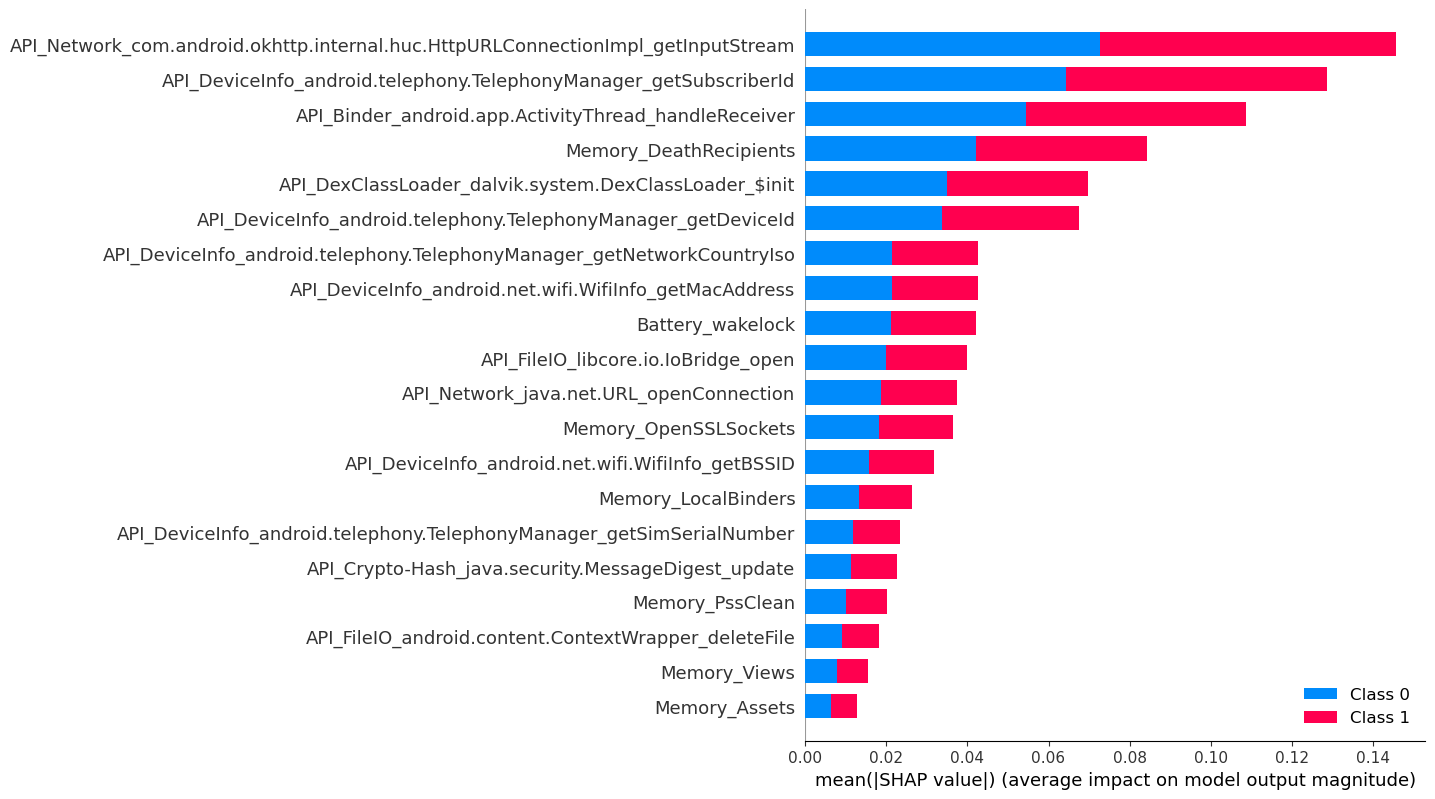

In [45]:
model = RandomForestClassifier(max_depth= 15, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split=2, n_estimators= 200)
model.fit(X_train_rfe_selected, y_train)

shap_df = pd.DataFrame(shap_values[1], columns=common_feature_names)

# Explain the model's predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_rfe_selected)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_rfe_selected, feature_names=common_feature_names)

plt.show()

In [10]:
categories = ['Airpush', 'Dowgin']

Category: Airpush, Image Size: 315 x 315 pixels
Category: Dowgin, Image Size: 368 x 368 pixels


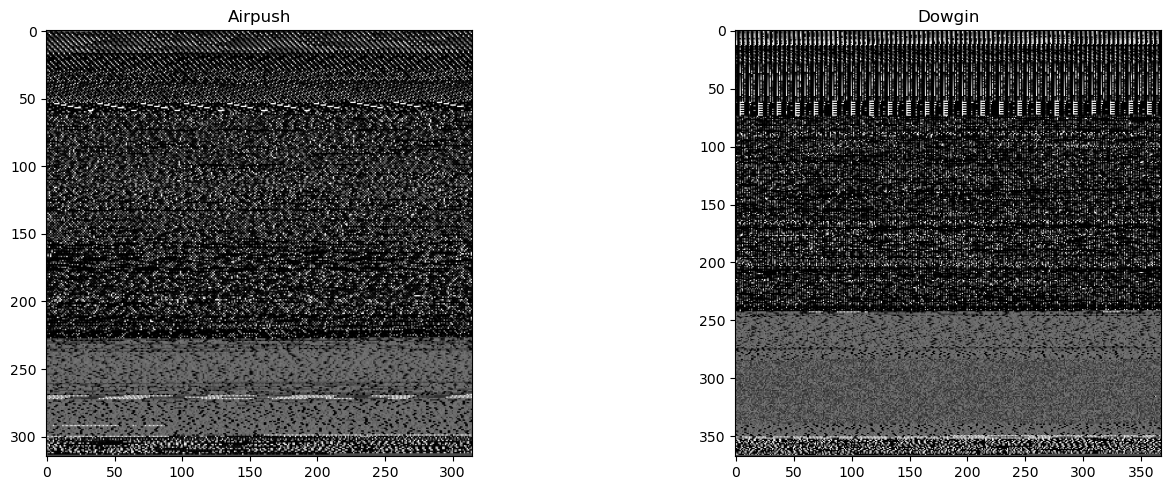

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, category in enumerate(categories):
    category_folder = os.path.join(train_path, category)

    image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]

    random_image_file = random.choice(image_files)

    random_image_path = os.path.join(category_folder, random_image_file)

    random_image = Image.open(random_image_path)

    image_size = random_image.size

    print(f"Category: {category}, Image Size: {image_size[0]} x {image_size[1]} pixels")

    axes[i].imshow(random_image)

    axes[i].set_title(category)

plt.tight_layout()
plt.show()

In [12]:
category_counts = {}

for category in categories:
    category_folder = os.path.join(train_path, category)
    image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]
    category_counts[category] = len(image_files)

for category, count in category_counts.items():
    print(f"{category}: {count} samples")

Airpush: 749 samples
Dowgin: 489 samples


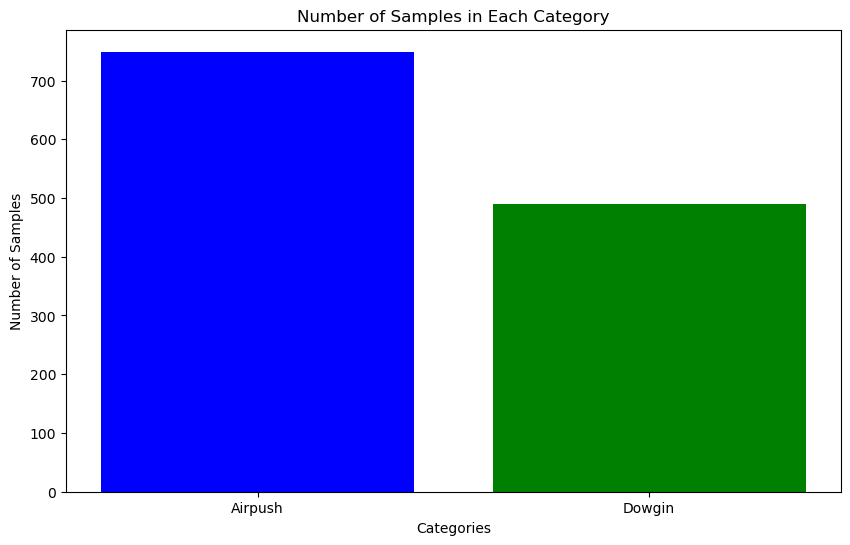

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(category_counts.keys(), category_counts.values(), color=['blue', 'green', 'red'])
ax.set_xlabel('Categories')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Category')
plt.show()

In [14]:
target_size = (200, 200)

resized_dir = r"android-work\resized"

categories = os.listdir(train_path)

# Loop through both train and validation directories
for dataset_path in [train_path, validation_path]:
    for category in categories:
        category_folder = os.path.join(dataset_path, category)
        resized_category_folder = os.path.join(resized_dir, category)

        os.makedirs(resized_category_folder, exist_ok=True)

        image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]

        for image_file in tqdm(image_files, desc=f"Processing {dataset_path}/{category}"):
            input_image_path = os.path.join(category_folder, image_file)
            output_image_path = os.path.join(resized_category_folder, image_file)

            image = Image.open(input_image_path)

            # Resize the image
            resized_image = image.resize(target_size)

            # Save the resized image
            resized_image.save(output_image_path)

print("Resizing complete.")

Processing android-work\val/Dowgin: 100%|██████████| 122/122 [00:04<00:00, 24.45it/s]

Resizing complete.


In [15]:
normalized_dir = r"android-work\normalized" 

categories = os.listdir(resized_dir)

for category in categories:
    category_folder_resized = os.path.join(resized_dir, category)
    category_folder_normalized = os.path.join(normalized_dir, category)

    # Create the 'normalized' directory if it doesn't exist
    os.makedirs(category_folder_normalized, exist_ok=True)

    image_files = [f for f in os.listdir(category_folder_resized) if f.endswith('.png')]

    for image_file in image_files:
        input_image_path = os.path.join(category_folder_resized, image_file)
        output_image_path = os.path.join(category_folder_normalized, image_file)

        image = Image.open(input_image_path)

        image_array = np.array(image)

        normalized_image = (image_array / 127.5) - 1.0

        # Save the normalized image to the 'normalized' directory
        normalized_image = Image.fromarray((normalized_image * 127.5 + 127.5).astype(np.uint8))
        normalized_image.save(output_image_path)

print("Normalization complete.")

Normalization complete.


Category: Airpush, Image Size: 200 x 200 pixels
Category: Dowgin, Image Size: 200 x 200 pixels


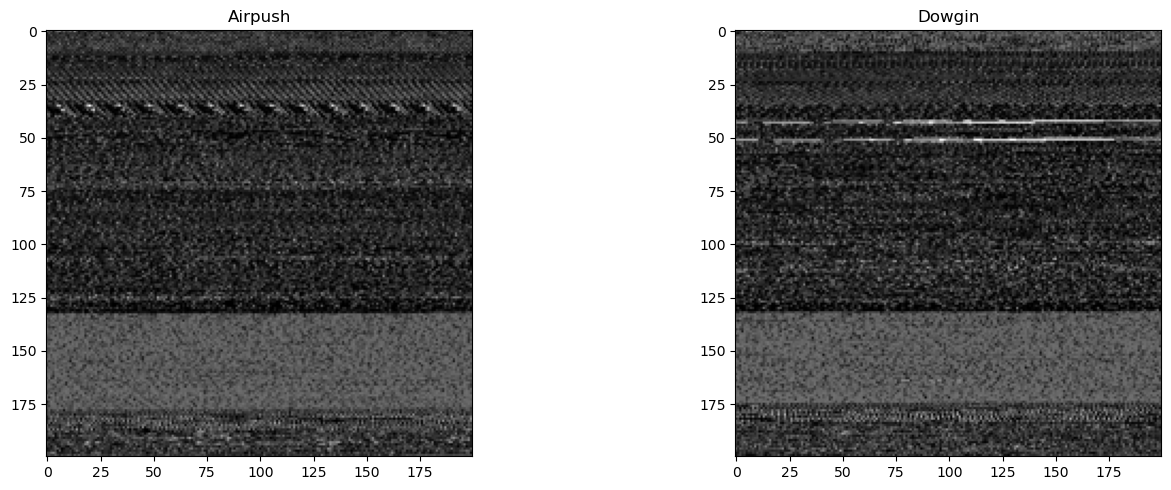

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, category in enumerate(categories):
    category_folder = os.path.join(normalized_dir, category)

    image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]

    random_image_file = random.choice(image_files)

    random_image_path = os.path.join(category_folder, random_image_file)

    random_image = Image.open(random_image_path)

    image_size = random_image.size

    print(f"Category: {category}, Image Size: {image_size[0]} x {image_size[1]} pixels")

    axes[i].imshow(random_image)

    axes[i].set_title(category)

plt.tight_layout()
plt.show()

In [11]:
img_train_dir = r"android-work\normalized"
img_test_dir = r"android-work\test"


def load_images_from_directory(directory, target_size=(200, 200)):
    images = []
    labels = []

    class_folders = os.listdir(directory)

    class_label_mapping = {class_folder: i for i, class_folder in enumerate(class_folders)}

    for i, class_folder in enumerate(class_folders):

        class_path = os.path.join(directory, class_folder)

        for image_file in os.listdir(class_path):
            if image_file.endswith('.png'):
                image_path = os.path.join(class_path, image_file)

                img = Image.open(image_path)
                img_array = np.array(img)

                # Resize the image while maintaining the original aspect ratio
                img_resized = resize(img_array, target_size, anti_aliasing=True)

                images.append(img_resized)
                labels.append(i)

    # Print class name to label mapping (excluding the specified class)
    print("Class Name to Label Mapping")
    for class_name, label in class_label_mapping.items():
            print(f"{class_name}: {label}")

    return np.array(images), np.array(labels)
train_images, train_labels = load_images_from_directory(img_train_dir)
test_images, test_labels = load_images_from_directory(img_test_dir)

Class Name to Label Mapping
Airpush: 0
Dowgin: 1
Class Name to Label Mapping
Airpush: 0
Dowgin: 1


In [12]:
input_shape = (200, 200, 2)
# the only change 

image_model = Sequential()

image_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
image_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
image_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))

image_model.add(MaxPooling2D(pool_size=(5, 5)))
image_model.add(MaxPooling2D(pool_size=(5, 5)))

image_model.add(Flatten())

image_model.add(Dense(X_train_rfe_selected.shape[1], activation='relu'))

# Output layer
image_model.add(Dense(1, activation='sigmoid'))

In [21]:
image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 64)      3264      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      102464    
                                                                 
 conv2d_2 (Conv2D)           (None, 188, 188, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [13]:
image_model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy', metrics.Precision(), metrics.Recall(), 
                                                                          F1Score(threshold=0.5, average=None, num_classes = 1)])

In [14]:
# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

In [15]:
train_labels_one_hot = np.array(train_labels)

In [16]:
test_labels_one_hot = np.array(test_labels)

In [17]:
X_train_images, X_val_images, y_train_images, y_val_images = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

In [18]:
epochs = 10 
batch_size = 32  

history_img = image_model.fit(X_train_images, y_train_images, epochs=epochs, batch_size=batch_size, validation_data=(X_val_images, y_val_images))
image_model.save('model.h5')

Epoch 1/10
39/39 [==============================] - 439s 11s/step - loss: 0.6832 - accuracy: 0.6015 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6759 - val_accuracy: 0.6194 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
39/39 [==============================] - 434s 11s/step - loss: 0.6459 - accuracy: 0.6249 - precision: 1.0000 - recall: 0.0588 - f1_score: 0.1111 - val_loss: 0.5232 - val_accuracy: 0.8032 - val_precision: 0.8608 - val_recall: 0.5763 - val_f1_score: 0.6904
Epoch 3/10
39/39 [==============================] - 436s 11s/step - loss: 0.4609 - accuracy: 0.8003 - precision: 0.8187 - recall: 0.6410 - f1_score: 0.7190 - val_loss: 0.3174 - val_accuracy: 0.8290 - val_precision: 0.9710 - val_recall: 0.5678 - val_f1_score: 0.7166
Epoch 4/10
39/39 [==============================] - 436s 11s/step - loss: 0.4112 - accuracy: 0.8375 - precision: 0.8411 - recall: 0.7302 - f1_score: 0.7818 - val_loss: 0.3648 - v

In [19]:
test_loss, test_accuracy = image_model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

13/13 [==============================] - 32s 2s/step - loss: 0.1129 - accuracy: 0.9560 - precision: 0.9193 - recall: 0.9737 - f1_score: 0.9457


ValueError: too many values to unpack (expected 2)

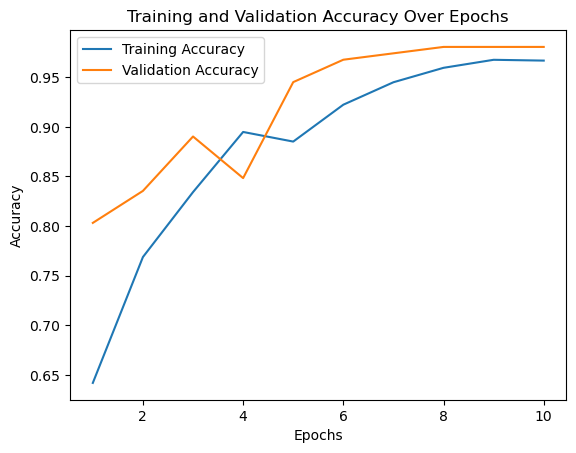

In [20]:
train_accuracy = history_img.history['accuracy']
val_accuracy = history_img.history['val_accuracy']

epochs_range = range(1, epochs + 1)

# Plotting the training and validation accuracy
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Get the gradient of the predicted class with regard to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the class channel with respect to the output feature
    grads = tape.gradient(class_channel, last_conv_layer_output)

     # Add a new axis to pooled_grads before matrix multiplication
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Reduce along both spatial dimensions

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    pooled_grads = tf.broadcast_to(pooled_grads, last_conv_layer_output.shape)  # Reduce along both spatial dimensions
    heatmap = tf.reduce_sum(last_conv_layer_output * pooled_grads, axis=-1)

    # ReLU on the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)


    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize the heatmap to original image size
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    # Display the superimposed image
    plt.imshow(superimposed_img[0])

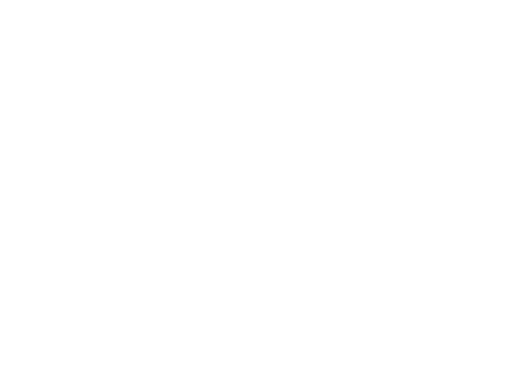

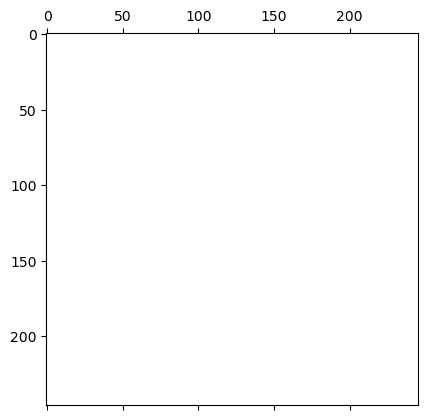

In [ ]:
# Example usage
model = load_model('model.h5')  # Load your trained model
img_path = 'android-work\\normalized\\Airpush\\Airpush_variety1_008662eda2d093197d3725df0f3263f0.apk.png'
size = (258, 258)  # Input size expected by the model

img_array = get_img_array(img_path, size)

last_conv_layer_name = 'conv2d_13'  # Replace with the name of the last convolutional layer in your model
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.axis('off')
plt.matshow(heatmap)
plt.show()

In [ ]:
display_gradcam(img_path, heatmap)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


AttributeError: 'str' object has no attribute 'shape'

In [43]:
X_train_images_resized= np.array([cv2.resize(image,(128,128)) for image in X_train_images])
# X_train_images_resized=X_train_images_resized.reshape(-1,128,128,3)

KeyboardInterrupt: 

In [ ]:
print(X_train_images_resized.shape)

(1237, 128, 128, 3)


In [29]:
print(y_train_images.shape)

(1237,)


In [27]:
y_train_images = np.array(y_train_images)

# indices to sort y_train_images
sorted_indices = np.argsort(np.squeeze(y_train_images))

# sort X_train_images and y_train_images
X_train_images = X_train_images[sorted_indices]
y_train_images = y_train_images[sorted_indices]

In [31]:
print(X_train_images.shape)

(1237, 200, 200, 2)


In [28]:
y_train = np.array(y_train)

# indices to sort y_train_images
sorted_indices = np.argsort(y_train)

# sort X_train_images and y_train_images
X_train_rfe = X_train_rfe_selected[sorted_indices]
y_train = y_train[sorted_indices]

In [29]:
# Get the number of samples in X_train_images
num_samples = X_train_images.shape[0]

# Randomly select a subset of X_train_pca and y_train
indices = np.random.choice(X_train_rfe.shape[0], size=num_samples, replace=False)
X_train_rfe_subset = X_train_rfe[indices]
y_train_subset = y_train[indices]

In [34]:
print(X_train_rfe_subset.shape)

(1237, 46)


In [30]:
# Define the tabular input
tabular_input = Input(shape=(X_train_rfe.shape[1],), name='tabular_input')
tabular_dense = Dense(32, activation='relu')(tabular_input)

# Define the image input
image_input = Input(shape=(200, 200, 2), name='image_input')
conv_layer = layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(image_input)
flatten_layer = Flatten()(conv_layer)

# Concatenate the outputs of tabular and image models
concatenated = layers.Concatenate()([tabular_dense, flatten_layer])

# common feedforward neural network
common_dense = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(common_dense)

# Create the final model
model = Model(inputs=[tabular_input, image_input], outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy', metrics.Precision(), metrics.Recall(), 
                                                                          F1Score(threshold=0.5, average=None, num_classes = 1)])
history_img = model.fit([X_train_rfe_subset, X_train_images], y_train_subset, epochs=20, batch_size=32)

Epoch 1/20
39/39 [==============================] - 47s 965ms/step - loss: 5.6638 - accuracy: 0.6386 - precision_3: 0.3587 - recall_3: 0.2083 - f1_score: 0.2636
Epoch 2/20
39/39 [==============================] - 34s 863ms/step - loss: 0.6871 - accuracy: 0.6896 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 3/20
39/39 [==============================] - 38s 970ms/step - loss: 0.6815 - accuracy: 0.6896 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 4/20
39/39 [==============================] - 34s 876ms/step - loss: 0.6761 - accuracy: 0.6896 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 5/20
39/39 [==============================] - 38s 965ms/step - loss: 0.6712 - accuracy: 0.6896 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 6/20
39/39 [==============================] - 40s 1s/step - loss: 0.6664 - accuracy: 0.6896 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 

In [113]:
X_test_images_resized= np.array([cv2.resize(image,(128,128)) for image in test_images])
print(X_test_images_resized.shape)

(386, 128, 128, 2)


In [107]:
print(test_labels_one_hot.shape)

(386,)


In [39]:
y_test_images = np.array(test_labels_one_hot)

# indices to sort y_train_images
sorted_indices = np.argsort(np.squeeze(y_test_images))

# sort X_train_images and y_train_images
X_test_images = test_images[sorted_indices]
y_test_images = y_test_images[sorted_indices]

In [40]:
print(X_test_images.shape)

(386, 200, 200, 2)


In [40]:
y_test = np.array(y_test)

# indices to sort y_train_images
sorted_indices = np.argsort(y_test)

# sort X_train_images and y_train_images
X_test_rfe = X_test_rfe_selected[sorted_indices]
y_test = y_test[sorted_indices]

In [41]:
num_samples = X_test_images.shape[0]

indices = np.random.choice(X_test_rfe.shape[0], size=num_samples, replace=False)
X_test_rfe_subset = X_test_rfe[indices]
y_test_subset = y_test[indices]

In [43]:
print(X_test_rfe_subset.shape)

(386, 59)


In [44]:
print(X_test_images.shape)

(386, 200, 200, 2)


In [42]:
loss, accuracy = model.evaluate([X_test_rfe_subset, X_test_images], y_test_subset)
print(f'Test accuracy: {accuracy}')

13/13 [==============================] - 2s 87ms/step - loss: 0.8136 - accuracy: 0.6762 - precision_4: 0.4182 - recall_4: 0.1983 - f1_score: 0.2690


ValueError: too many values to unpack (expected 2)